# Double Descent 
## Christian Igel, 2023

This code is based on the [Double Descent Demystified: Identifying, Interpreting & Ablating the Sources of a Deep Learning Puzzle](https://arxiv.org/abs/2303.14151) by
Rylan Schaeffer, Mikail Khona, Zachary Robertson, Akhilan Boopathy, Kateryna Pistunova, Jason W. Rocks, Ila Rani Fiete, Oluwasanmi Koyejo.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

### Function to fit
Just some artificial function.

In [2]:
def func(x):
    return 2*x+np.sin(25*x)
def func_gen(N_samples, resolution=500):
    x_min = -1.
    x_max = 1.
    xline = np.linspace(x_min, x_max, resolution)
    x = np.random.choice(xline, size=N_samples)
    y = func(x)
    yline = func(xline)
    return (x.reshape(-1,1), y, xline.reshape(-1,1), yline)
    

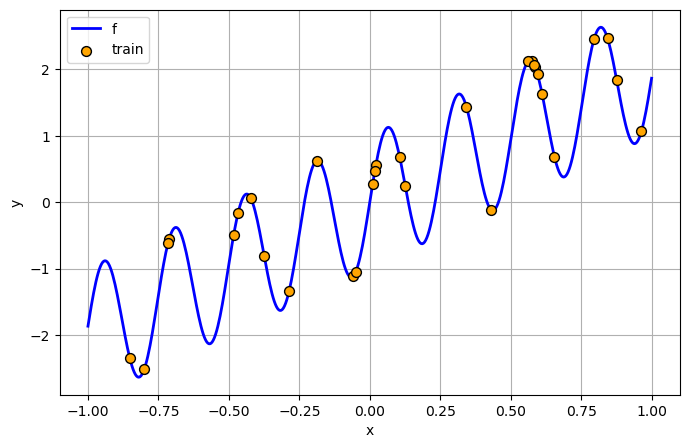

In [3]:
# Generate training data
np.random.seed(1)  # play with the seed
N = 30
X_train_raw, y_train, X_test_raw, y_test = func_gen(N)

# Plot function and sampled points
plt.figure(figsize=(8,5))
plt.plot(X_test_raw, y_test,c='b',lw=2, label='f')
plt.scatter(X_train_raw, y_train, edgecolors='k', c='orange', s=50, label='train', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

### Legendre polynomial

We use a polynomial feature embedding. The type of polynomial features matters. 
We consider Legendre polynomials, which look like this:

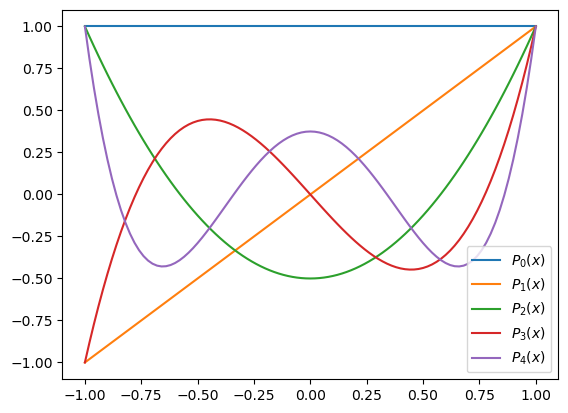

In [4]:
max_degree = 4
xlin = np.linspace(-1, 1, 101).reshape(-1, 1)
leg = np.polynomial.legendre.legval(xlin, np.eye(max_degree + 1), tensor=False)
for _d in range(0, max_degree + 1):
    plt.plot(xlin, leg[:,_d], label=r'$P_{}(x)$'.format(_d))
plt.legend();

### Linear regression using polynomial embedding

This function perfromns linear regression using polynomial embedding.
One can specify the `degree` of the polynomial and thetype, where `std` refers to the standard polynomial embedding and `Legendre` to using Legendre polynomials.


In [5]:
def do_it(degree = 10, poly_type='std', verbose=False):
    if poly_type=='Legendre':
        X_train = np.polynomial.legendre.legval(X_train_raw, np.eye(degree+1), tensor=False)
        X_test = np.polynomial.legendre.legval(X_test_raw, np.eye(degree+1), tensor=False)
    else:
        poly = PolynomialFeatures(degree=degree, interaction_only=False, include_bias=True)
        X_train = poly.fit_transform(X_train_raw)
        X_test = poly.transform(X_test_raw)

    N, d = X_train.shape
        
    # Solve for the best possible approximate solution in terms of least squares using SVD
    U, S, Vt = np.linalg.svd(X_train, full_matrices=False)
    beta = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T @ y_train
    # Alternative: beta = np.linalg.pinv(X_train, rcond=1e-16) @ y_train
        
    norm = np.linalg.norm(beta)
    
    # perform train and test inference
    y_pred = X_train @ beta
    y_pred_test = X_test @ beta
    
    return (y_pred, y_pred_test, norm)

In [6]:
poly_type='Legendre'
#poly_type='std'
e_train = []
e_test = []
beta_norm = []

for degree in range(0, 101):
    y_pred, y_pred_test, norm = do_it(degree, poly_type=poly_type)
    if(degree == N-1):
        y_pred_unique, y_pred_test_unique= y_pred, y_pred_test
    e_train.append(mean_squared_error(y_pred, y_train))
    e_test.append(mean_squared_error(y_pred_test, y_test))
    beta_norm.append(norm)

Plot results. The plot is cut at 0.001 to hide numerical trouble (uncomment `plt.ylim(0.001)` to face the truth).
To compute the norm, we view all points as living in the space with the highest dimensionality.

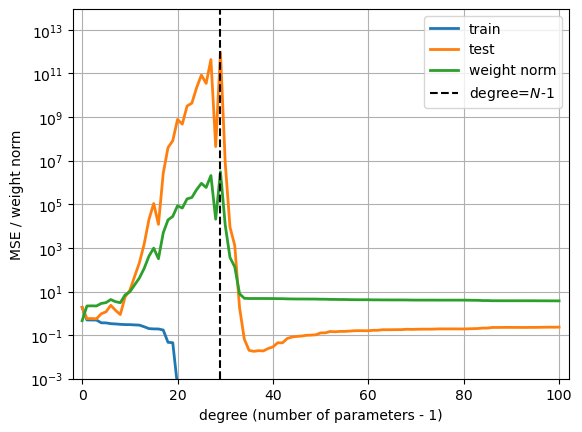

In [16]:
plt.plot(e_train, label = 'train', lw=2);
plt.plot(e_test, label = 'test', lw=2);
plt.plot(beta_norm, label = 'weight norm', lw=2);
plt.yscale('log')
plt.axvline(x = N-1, color = 'k', linestyle='dashed', label = 'degree=$N$-1')
plt.grid(True)
plt.xlabel('degree (number of parameters - 1)')
plt.ylabel('MSE / weight norm')
plt.ylim(0.001)
plt.legend()
plt.xlim(-2,102)
plt.savefig("doubleDescent.pdf")
plt.show()

Visualization of the solution with the most features and the one with as many features (degree plus 1) as training data points.

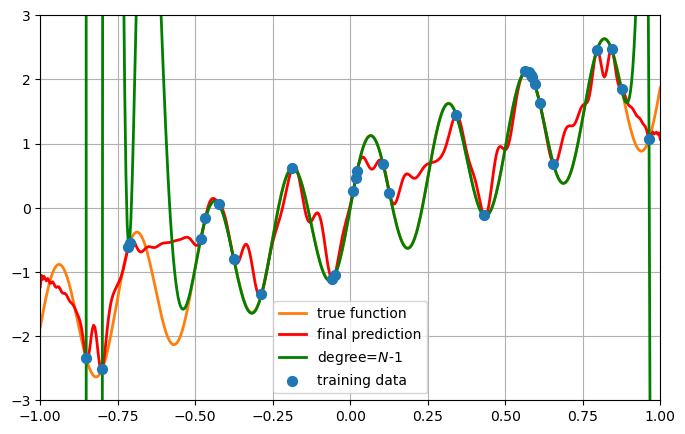

In [17]:
plt.figure(figsize=(8,5))
plt.ylim(-3, 3)
plt.plot(X_test_raw, y_test, color='C1', label='true function', lw=2)
plt.plot(X_test_raw, y_pred_test, c='r',label="final prediction", lw=2)
plt.plot(X_test_raw, y_pred_test_unique, c='g',label="degree=$N$-1", lw=2)
plt.scatter(X_train_raw, y_train, c='C0', s=50, label="training data", zorder=5)
plt.xlim(-1,1)
plt.legend()
plt.grid(True)
plt.savefig("doubleDescentFit.pdf")
plt.show()